<a href="https://colab.research.google.com/github/derek-shing/DS-Unit2-Sprint5-Kaggle/blob/master/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading Data

In [0]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

In [1]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 3.8MB/s 


In [165]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
train_features = pd.read_csv('/content/gdrive/My Drive/train_features.csv')
train_labels = pd.read_csv('/content/gdrive/My Drive/train_labels.csv')
test_features = pd.read_csv('/content/gdrive/My Drive/test_features.csv')
submission = pd.read_csv('/content/gdrive/My Drive/sample_submission.csv')


construction_year_median = train_features[train_features['construction_year']!=0]['construction_year'].median()

install_less_than_300 =  train_features['installer'].value_counts()[train_features['installer'].value_counts()<300].index
install_less_than_300= list(install_less_than_300)
funder_less_than_100 =  train_features['funder'].value_counts()[train_features['funder'].value_counts()<100].index
funder_less_than_100= list(funder_less_than_100)

population_median = train_features[train_features['population']!=0].groupby('region_code').agg('median')
population_median = population_median.reset_index()
population_median = population_median[['region_code','population']]
population_median = population_median.rename(columns={'population':'population_median'})

total_population_median = train_features[train_features['population']!=0]['population'].median()


In [278]:
train_features.shape, train_labels.shape, test_features.shape

((59400, 40), (59400, 2), (14358, 40))

In [0]:
pd.options.display.max_columns=999
pd.options.display.max_rows=999

In [0]:
y_train = train_labels['status_group']
X_train = train_features.drop(columns='id')
X_test  = test_features.drop(columns='id')

In [281]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((44550, 39), (14850, 39), (44550,), (14850,))

In [210]:
y_train.value_counts(normalize=True)

functional                 0.544691
non functional             0.382514
functional needs repair    0.072795
Name: status_group, dtype: float64

In [0]:
X_train.isnull().sum()

# Study Relation (Can skip)

In [0]:
X_y =X_train.copy()

In [0]:
X_y['y']=y_train

In [11]:
X_y.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'y'],
      dtype='object')

In [0]:
pd.pivot_table(X_y,index=["permit"],values=["y"],aggfunc=[np.sum])

In [0]:
X_y.public_meeting.isnull().sum()

In [0]:
X_y.funder.value_counts()

In [0]:
X_train_numeric.water_quality.value_counts()

In [0]:
train_features['year']=train_features.date_recorded.str.split('-')

In [0]:
train_features['year']=train_features['year'].map(lambda x: x[0])

In [0]:
X_train.population.value_counts()

In [0]:
population_median = train_features[train_features['population']!=0].groupby('region_code').agg('median')
population_median = population_median.reset_index()
population_median = population_median[['region_code','population']]
population_median = population_median.rename(columns={'population':'population_median'})

In [0]:
population_median

In [0]:
df = pd.merge(X_train, population_median)
df['population'].value_counts()
condition=(df['population']==0)
p_median = df[condition]['population_median']
df.loc[condition,'population']=p_median

In [0]:
df.head().T

In [0]:
df['population'].value_counts()

In [0]:
X_train_numeric[X_train_numeric['region_code']==1]

In [0]:
X_train[X_train['construction_year']==0].region_code.value_counts()

In [52]:
X_train[(X_train['region_code']==17) & (X_train['construction_year']!=0)].describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,127.000000,127.000000,127.000000,127.000000,127.0,127.0,127.0,127.000000,127.000000
mean,432.283465,1350.874016,34.167374,-2.963943,0.0,17.0,1.0,420.637795,2002.070866
std,4436.462946,27.283634,0.111047,0.045715,0.0,0.0,0.0,238.024598,5.821663
min,0.000000,1301.000000,33.982075,-3.075578,0.0,17.0,1.0,1.000000,1985.000000
25%,0.000000,1332.500000,34.075239,-2.989430,0.0,17.0,1.0,300.000000,1997.000000
50%,0.000000,1352.000000,34.144579,-2.970811,0.0,17.0,1.0,500.000000,2005.000000
75%,0.000000,1370.000000,34.258415,-2.933263,0.0,17.0,1.0,500.000000,2007.000000
max,50000.000000,1434.000000,34.398348,-2.858905,0.0,17.0,1.0,1500.000000,2012.000000


In [0]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=iris.feature_names).sort_values(ascending=False)

In [0]:
rf = m.named_steps['randomforestclassifier']

In [0]:
X_train_numeric.amount_tsh.value_counts()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


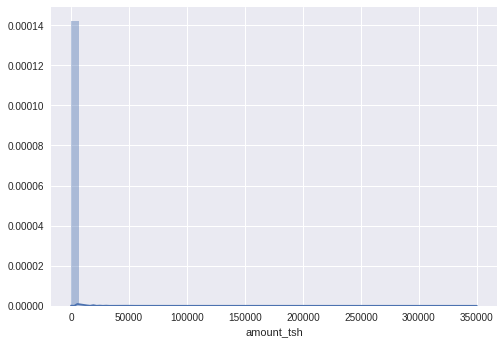

In [274]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(X_train_numeric.amount_tsh)

In [0]:
feature_imp = rf.feature_importances_

In [0]:
pd.Series(feature_imp)

In [275]:
X_train_numeric.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'num_private', 'basin', 'region_code', 'district_code',
       'lga', 'population', 'public_meeting', 'recorded_by', 'permit',
       'construction_year', 'extraction_type', 'management', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_type', 'waterpoint_type', 'year', 'month', 'Age'],
      dtype='object')

#Modeling and Training

In [0]:
def wrangle_3(X):
  X = X.copy()
  low_cardinality = ['basin','region',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quantity', 'source', 'source_type','quantity_group',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']
  
  #install_less_than_300 =  X['installer'].value_counts()[X['installer'].value_counts()<300].index
  #install_less_than_300= list(install_less_than_300)
  #print(install_less_than_300)
  X[X['installer'].isin(install_less_than_300)]['installer']='Other'
  X['installer']=X['installer'].fillna('Other')
  
  X[X['funder'].isin(funder_less_than_100)]['funder']='Other'
  X['funder']=X['funder'].fillna('Other')
  
  #X.installer.value_counts()
  
  #X=pd.get_dummies(X,columns=low_cardinality)
  quality_group_map = {'unknown':0,'salty':1,'milky':2,'colored':3,'fluoride':4,'good':5}
  X['quality_group'] =  X['quality_group'].map(quality_group_map)
  #X['quality_group_square']=X['quality_group']**2
  
  #quantity_map ={'dry':0,'insufficient':1,'unknown':2,'seasonal':3,'enough':4}
  #X['quantity'] = X['quantity'].replace(quantity_map)
  
  X['permit']=X['permit'].fillna(False)
  X['permit']=X['permit'].replace({True:1,False:0})
 
  X['public_meeting']=X['public_meeting'].fillna(False)
  X['public_meeting']=X['public_meeting'].replace({True:1,False:0})  
  
  X = pd.merge(X, population_median, how='left')
  condition=(X['population']==0)
  p_median = X[condition]['population_median']
  X.loc[condition,'population']=p_median
  X['population'] = X['population'].fillna(total_population_median)
  
   
  #other_feature_drop=['amount_tsh','longitude','latitude']
  #X=X.drop(other_feature_drop,axis=1)
  
  subclass_feature=['extraction_type_class','extraction_type_group','quantity_group',
                    'waterpoint_type_group','management_group','source_class','region','population_median']
  X=X.drop(subclass_feature,axis=1)
  
  
  X['construction_year'] = X['construction_year'].replace({0:construction_year_median})
  
  X['temp']=X.date_recorded.str.split('-')
  X['year']=X['temp'].map(lambda x: x[0])
  X['year']=pd.to_numeric(X['year'])
  
  X['month']=X['temp'].map(lambda x: x[1])
  
  X['Age']=X['year']-X['construction_year']
  
  
  high_cardinality =['date_recorded','wpt_name','subvillage','ward','scheme_name']
  X=X.drop(high_cardinality, axis=1)
  X=X.drop(['scheme_management','temp'], axis=1)
  
  train_features
  #X['Age_square']=(2018-X['construction_year'])**2
  #print(X.isnull().sum())
  #print(X.columns)
  return X


In [283]:
X_train_numeric = wrangle_3(X_train)
X_val_numeric = wrangle_3(X_val)
X_test_numeric = wrangle_3(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [284]:
X_train_numeric.shape, X_val_numeric.shape,X_test_numeric.shape

((44550, 26), (14850, 26), (14358, 26))

In [285]:
X_train_numeric.isnull().sum()

funder               0
gps_height           0
installer            0
num_private          0
basin                0
region_code          0
district_code        0
lga                  0
population           0
public_meeting       0
recorded_by          0
permit               0
construction_year    0
extraction_type      0
management           0
payment              0
payment_type         0
water_quality        0
quality_group        0
quantity             0
source               0
source_type          0
waterpoint_type      0
year                 0
month                0
Age                  0
dtype: int64

In [0]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    #LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=10000)
    #KNeighborsClassifier()
    RandomForestClassifier(n_estimators=200)
)


In [0]:
status_map={'non functional':0,'functional needs repair':1,'functional':2}

In [0]:
y_train = y_train.replace(status_map)

In [289]:
m = pipeline.fit(X_train_numeric,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


#Old Transform

In [0]:
def wrangle(X):
  X = X.copy()
  low_cardinality = ['basin','region',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quantity', 'source', 'source_type','quantity_group',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']
  
  X=pd.get_dummies(X,columns=low_cardinality)
  quality_group_map = {'unknown':0,'salty':1,'milky':2,'colored':3,'fluoride':4,'good':5}
  X['quality_group'] =  X['quality_group'].map(quality_group_map)
  X['quality_group_square']=X['quality_group']**2
  
  X = X.select_dtypes(np.number)
  
  
  return X

def wrangle_OneCode(X):
  X = X.copy()
  low_cardinality = ['basin','region',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quantity', 'source', 'source_type','quantity_group',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']
  
  #install_less_than_300 =  X['installer'].value_counts()[X['installer'].value_counts()<300].index
  #install_less_than_300= list(install_less_than_300)
  #print(install_less_than_300)
  X[X['installer'].isin(install_less_than_300)]['installer']='Other'
  X['installer']=X['installer'].fillna('Other')
  
  #X.installer.value_counts()
  
  #X=pd.get_dummies(X,columns=low_cardinality)
  quality_group_map = {'unknown':0,'salty':1,'milky':2,'colored':3,'fluoride':4,'good':5}
  X['quality_group'] =  X['quality_group'].map(quality_group_map)
  #X['quality_group_square']=X['quality_group']**2
   
  high_cardinality =['date_recorded','funder','wpt_name','subvillage','ward','scheme_name']
  X=X.drop(high_cardinality, axis=1)
  X=X.drop(['public_meeting','scheme_management','permit'], axis=1)
  
  subclass_feature=['extraction_type_class','extraction_type_group']
  #X=X.drop(subclass_feature,axis=1)
  
  #X['construction_year'].replace({0:construction_year_mean})
  #X['Age_square']=(2018-X['construction_year'])**2
  #print(X.isnull().sum())
  #print(X.columns)
  return X


# predict and val

In [290]:
y_pred=m.predict(X_val_numeric)

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [0]:
y_val=y_val.map(status_map)

In [0]:
y_pred

In [0]:
y_val

In [292]:
accuracy_score(y_val,y_pred)

0.7933333333333333

In [293]:
pd.Series(y_pred).value_counts()

2    8733
0    5350
1     767
dtype: int64

#Testing

In [256]:
y_pred=m.predict(X_test_numeric)

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [0]:
y_pred = pd.Series(y_pred)

In [0]:
y_pred

In [0]:
status_map_r = {0:'non functional',1:'functional needs repair',2:'functional'}

In [0]:
y_pred = y_pred.replace(status_map_r)

In [261]:
y_pred.value_counts(normalize=True)

functional                 0.574523
non functional             0.372406
functional needs repair    0.053071
dtype: float64

In [0]:
submission['status_group']=y_pred

In [0]:
from google.colab import files

submission.to_csv('test_labels.csv',index=False)
files.download('test_labels.csv')